In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score # For K-Means evaluation
import plotly.express as px # For interactive 3D plot
import warnings
warnings.filterwarnings("ignore")

In [15]:
df = pd.read_csv('../machine learning/data.csv')


print("--- Aperçu initial des données ---")
print(f"Dimensions de la base : {df.shape}")
print("\nTypes de données des colonnes :")
print(df.info())

print("\nPremières lignes de la base :")
print(df.head())

print("\nStatistiques descriptives des colonnes numériques :")
print(df.describe())

print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())


# Conversion de la date
df['date_achat'] = pd.to_datetime(df['date_achat'])

--- Aperçu initial des données ---
Dimensions de la base : (10000, 22)

Types de données des colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_achat               10000 non-null  object 
 1   date_achat             10000 non-null  object 
 2   id_produit             10000 non-null  object 
 3   quantité               10000 non-null  int64  
 4   id_fournisseur         10000 non-null  object 
 5   prix_unitaire          10000 non-null  float64
 6   délai_livraison_jours  10000 non-null  int64  
 7   montant_total          10000 non-null  float64
 8   mois                   10000 non-null  int64  
 9   année                  10000 non-null  int64  
 10  jour_semaine           10000 non-null  int64  
 11  catégorie              10000 non-null  object 
 12  marque                 10000 non-null  object 
 13  pri

# Interprétation de l'Aperçu Initial des Données

L'analyse initiale de la base de données nous fournit des informations précieuses sur sa structure, la nature des données et sa qualité globale.

---

## 1. Structure Générale de la Base de Données

*   **Dimensions :** La base de données est de taille modérée, contenant **10000 enregistrements** (lignes) et **22 variables** (colonnes).
    *   `Dimensions de la base : (10000, 22)`
*   **Index :** Les enregistrements sont indexés de 0 à 9999.
    *   `RangeIndex: 10000 entries, 0 to 9999`
*   **Types de Données :**
    *   Il y a une diversité de types de données :
        *   **`object` (10 colonnes) :** Typiquement des chaînes de caractères, utilisées pour des identifiants (`id_achat`, `id_produit`, `id_fournisseur`), des dates stockées comme texte (`date_achat`), et des données catégorielles (`catégorie`, `marque`, `nom_fournisseur`, `ville`, `pays`, `entrepot`).
        *   **`int64` (8 colonnes) :** Nombres entiers, utilisés pour des quantités (`quantité`), des indicateurs temporels (`délai_livraison_jours`, `mois`, `année`, `jour_semaine`, `délai_moyen_jours`), et des seuils/niveaux (`stock_minimum`, `niveau_stock`).
        *   **`float64` (4 colonnes) :** Nombres décimaux, utilisés pour des valeurs monétaires (`prix_unitaire`, `montant_total`, `prix`) et des indicateurs de performance (`fiabilité`).
    *   `dtypes: float64(4), int64(8), object(10)`
*   **Utilisation Mémoire :** La base de données occupe environ **1.7+ MB** en mémoire.
    *   `memory usage: 1.7+ MB`

---

## 2. Qualité des Données (Valeurs Manquantes)

*   **Aucune valeur manquante** n'est détectée dans l'ensemble des 22 colonnes.
*   Cela indique une **excellente complétude des données** à ce stade, simplifiant les étapes de nettoyage initial.

---

## 3. Aperçu des Données (Premières Lignes)

Les premières lignes donnent un aperçu concret du contenu :

*   **Identifiants :** `id_achat` (ex: `PO000001`), `id_produit` (ex: `P00627`), `id_fournisseur` (ex: `S029`) semblent être des codes alphanumériques.
*   **Informations d'Achat :**
    *   `date_achat` (ex: `2024-03-22`) est stockée comme `object` et nécessitera une conversion en type `datetime` pour des analyses temporelles.
    *   `quantité` (ex: `150`), `prix_unitaire` (ex: `129.62`), `montant_total` (ex: `19443.0`). Il est probable que `montant_total` = `quantité` * `prix_unitaire`.
*   **Informations Produit :**
    *   `catégorie`, `marque` (ex: `Atelier Minéral`).
    *   `prix` (ex: `39.95`) : semble être un prix catalogue du produit, différent du `prix_unitaire` d'achat.
    *   `stock_minimum`, `niveau_stock`.
*   **Informations Fournisseur :**
    *   `nom_fournisseur` (ex: `Fontaine Lopes S.A.`), `ville` (ex: `Helsinki`), `pays` (ex: `Finlande`).
    *   `fiabilité` (ex: `0.54`), `délai_moyen_jours` (ex: `6`).
*   **Informations Logistiques :**
    *   `délai_livraison_jours` (ex: `14`).
    *   `entrepot` (ex: `Paris`).
*   **Composantes de Date :** `mois`, `année`, `jour_semaine` sont déjà extraites, probablement de `date_achat`.
*   **Encodage :** La valeur `Ã‰veil Ã‰légant` dans la colonne `marque` suggère un **problème d'encodage des caractères** (probablement UTF-8 lu comme Latin-1 ou vice-versa) qu'il faudra corriger.

---

## 4. Statistiques Descriptives (Colonnes Numériques)

*   **`quantité` :**
    *   Moyenne : 99.5
    *   Écart-type : 98.6 (forte dispersion)
    *   Min : 10, Max : 500
    *   Médiane (50%) : 75. La moyenne supérieure à la médiane suggère une distribution asymétrique à droite (quelques commandes de très grande quantité).
*   **`prix_unitaire` :**
    *   Moyenne : 155.19
    *   Min : 10.03, Max : 299.98
*   **`délai_livraison_jours` :**
    *   Moyenne : 7.96 jours (environ 8 jours)
    *   Min : 2, Max : 14 jours.
*   **`montant_total` :**
    *   Moyenne : 15530.71
    *   Écart-type : 19313.23 (très forte dispersion, encore plus marquée que pour `quantité`)
    *   Min : 100.30, Max : 148310.00
    *   Médiane (50%) : 9099.50. La moyenne significativement plus élevée que la médiane confirme la présence de montants de commande très élevés qui tirent la moyenne vers le haut.
*   **`mois` :** Les achats sont répartis sur tous les mois de l'année (Min 1, Max 12).
*   **`année` :**
    *   **Toutes les données concernent l'année 2024** (Moyenne, Min, Max, Quartiles tous à 2024, Écart-type de 0). C'est une information importante pour le contexte de l'analyse.
*   **`jour_semaine` :** Les valeurs vont de 0 à 6, représentant probablement les jours de la semaine (ex: Lundi=0 à Dimanche=6 ou inversement).
*   **`prix` (probablement prix catalogue produit) :**
    *   Moyenne : 258.29
    *   Min : 22.22, Max : 499.72. Ce prix est distinct et généralement plus élevé que le `prix_unitaire` d'achat moyen.
*   **`stock_minimum` :**
    *   Moyenne : 53.28
    *   Min : 10, Max : 99.
*   **`fiabilité` (probablement du fournisseur) :**
    *   Moyenne : 0.697 (environ 70%)
    *   Min : 0.5, Max : 1.0. Semble être un score normalisé entre 0.5 et 1.
*   **`délai_moyen_jours` (probablement du fournisseur) :**
    *   Moyenne : 7.05 jours
    *   Min : 3, Max : 14 jours.
*   **`niveau_stock` :**
    *   Moyenne : 147.77
    *   Min : 0 (des ruptures de stock existent ou ont existé), Max : 299.

---

## 5. Conclusions Préliminaires et Pistes

*   **Données Complètes :** La base est complète, sans valeurs manquantes, ce qui est un excellent point de départ.
*   **Problème d'Encodage :** Un problème d'encodage des caractères est visible (`Ã‰veil Ã‰légant`) et doit être traité.
*   **Conversion de Type :** La colonne `date_achat` doit être convertie en type `datetime` pour toute analyse temporelle.
*   **Contexte Temporel :** Toutes les données sont de **2024**. Cela limite les analyses de tendances sur plusieurs années mais simplifie les comparaisons au sein de cette année.
*   **Variables Clés pour l'Analyse :**
    *   Transactions : `quantité`, `prix_unitaire`, `montant_total`.
    *   Produits : `catégorie`, `marque`, `prix`.
    *   Fournisseurs : `nom_fournisseur`, `fiabilité`, `délai_moyen_jours`.
    *   Logistique : `délai_livraison_jours`, `niveau_stock`, `entrepot`.
*   **Potentiel d'Analyse :**
    *   Analyse des ventes par catégorie, marque, mois.
    *   Performance des fournisseurs (fiabilité, délais).
    *   Optimisation des stocks (`stock_minimum` vs `niveau_stock`).
    *   Relation entre `prix_unitaire` d'achat et `prix` catalogue.
    *   Analyse des montants de commande et identification des outliers.

Cette première exploration fournit une base solide pour des analyses plus approfondies.


--- Analyse exploratoire détaillée ---


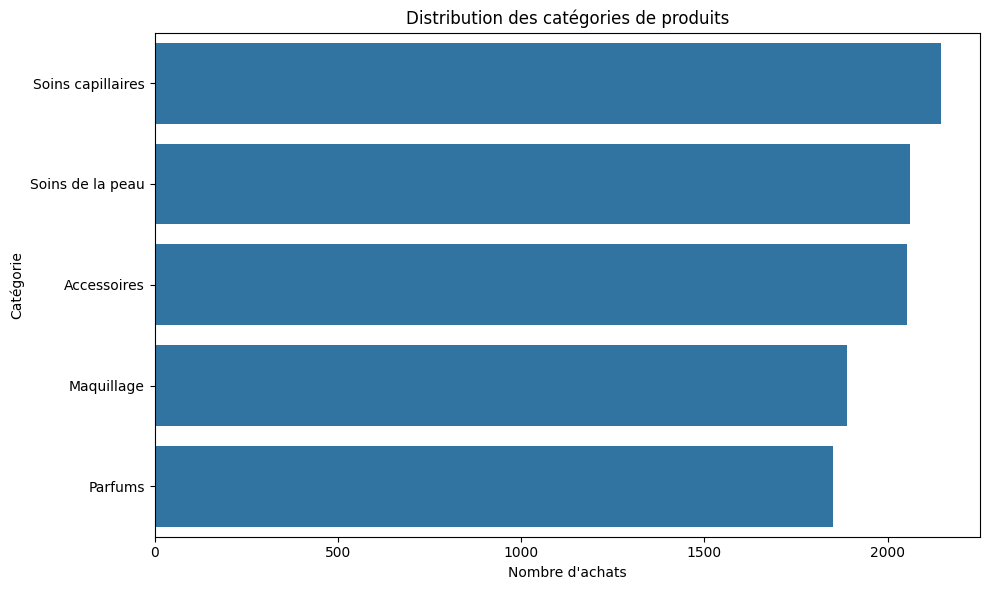

In [16]:
print("\n--- Analyse exploratoire détaillée ---")

# Distribution des catégories de produits
plt.figure(figsize=(10, 6))
sns.countplot(y=df['catégorie'], order=df['catégorie'].value_counts().index)
plt.title('Distribution des catégories de produits')
plt.xlabel('Nombre d\'achats')
plt.ylabel('Catégorie')
plt.tight_layout()
plt.show()

Le graphique à barres horizontales illustre la distribution des catégories de produits en fonction du nombre d'achats. 

**Analyse des catégories et de leur popularité (nombre d'achats) :** 

1. **Soins capillaires :** 
    - C'est la catégorie de produits la plus achetée.
    - Le nombre d'achats se situe légèrement au-dessus de 2100 (estimation : ~2120)

2. **Soins de la peau :** 
    - Arrive en deuxième position en termes de nombre d'achats.
    - Le volume d'achats est très proche de celui des soins capillaires, aux alentours de 2050 (estimation : ~2060).
    
La différence entre les deux catégories est minime, ce qui indique une forte demande pour les soins de la peau.

3. **Accessoires :** 
    - Se classe troisième.
    - Le nombre d'achats est légèrement supérieur à 2000 (estimation : ~2020).
    
4. **Maquillage :** 
    - Est la quatrième catégorie la plus achetée.
    - Le nombre d'achats se situe entre 1800 et 1900, plus proche de 1900 (estimation : ~1880).

5. **Parfums :**
    - Représente la catégorie la moins achetée parmi celles présentées.
    - Le nombre d'achats est d'environ 1800 (estimation : ~1830).

**Interprétation générale :** 
- Les produits de "Soins" (capillaires et de la peau) ainsi que les "Accessoires" sont les plus populaires auprès des acheteurs (ici, les entreprises achetant au fournisseur).
- Il y a une demande soutenue pour ces trois catégories, avec des volumes d'achats relativement similaires et les plus élevés. 
- Le "Maquillage" et les "Parfums", bien que significatifs, sont achetés en quantités légèrement inférieures par rapport aux trois premières catégories. 
- Les différences de volume d'achats entre les catégories ne sont pas drastiques, mais une hiérarchie claire se dessine, avec les "Soins capillaires" en tête. 

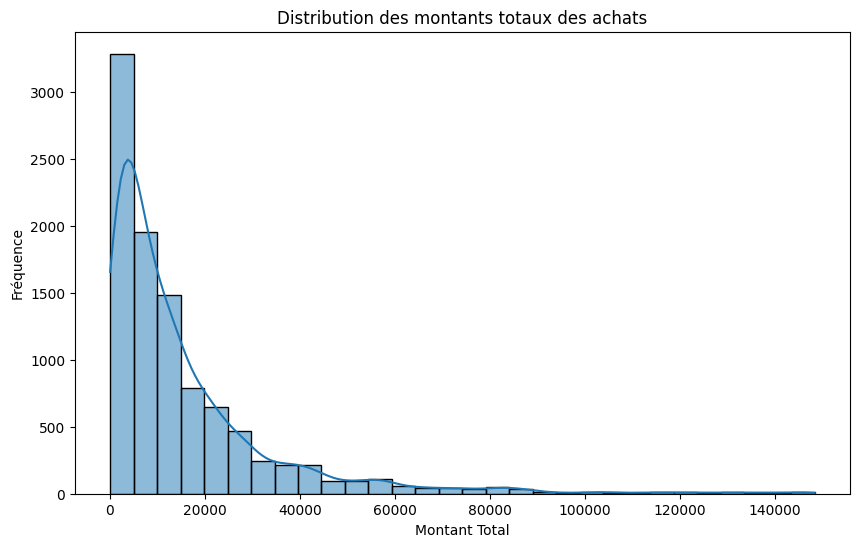

In [17]:
# Distribution des montants totaux
plt.figure(figsize=(10, 6))
sns.histplot(df['montant_total'], kde=True, bins=30)
plt.title('Distribution des montants totaux des achats')
plt.xlabel('Montant Total')
plt.ylabel('Fréquence')
plt.show()


## Observation Générale :
L'histogramme illustre la distribution de la variable `montant_total` des achats. Il est accompagné d'une courbe d'estimation de la densité (KDE) qui lisse la distribution.

## Caractéristiques Principales de la Distribution :

1.  **Asymétrie Positive (Skewness à Droite) :**
    *   La distribution est **fortement asymétrique à droite** (positive skew). Cela signifie que la majorité des achats ont des montants totaux relativement faibles, tandis qu'un petit nombre d'achats ont des montants totaux très élevés.
    *   La "queue" de la distribution s'étend loin vers les valeurs élevées sur l'axe des X.

2.  **Concentration des Valeurs :**
    *   La **majorité des transactions** (le pic le plus élevé de l'histogramme) se situe dans les **montants les plus bas**, probablement entre 0 et environ 10 000. La fréquence dépasse 3000 pour la première classe.
    *   La fréquence diminue rapidement à mesure que le montant total augmente. Par exemple, la fréquence des achats entre 10 000 et 20 000 est déjà significativement plus basse (autour de 2000).

3.  **Présence de Valeurs Élevées (Outliers Potentiels) :**
    *   Bien que moins fréquents, il existe des achats avec des montants totaux substantiels, allant jusqu'à environ 150 000.
    *   Ces transactions de grande valeur sont responsables de l'étirement de la queue de la distribution vers la droite.

## Corrélation avec les Statistiques Descriptives Précédentes :

Cette observation visuelle est cohérente avec les statistiques descriptives fournies précédemment pour `montant_total` :
*   **Moyenne (`mean`) : 15 530.71**
*   **Médiane (`50%`) : 9 099.50**
*   **Écart-type (`std`) : 19 313.23** (très élevé, indiquant une grande dispersion)
*   **Maximum (`max`) : 148 310.00**

Le fait que la **moyenne soit significativement plus élevée que la médiane** est une caractéristique classique des distributions asymétriques à droite. Les quelques valeurs très élevées tirent la moyenne vers le haut.

## Implications et Pistes d'Analyse :

*   **Nature des Transactions :** La plupart des achats sont de faible valeur, mais quelques transactions de grande valeur existent. Il serait intéressant d'identifier ce qui caractérise ces achats à montant élevé (types de produits, fournisseurs, etc.).
*   **Segmentation :** Il pourrait être pertinent de segmenter les analyses. Par exemple, analyser séparément les achats "courants" (faible montant) et les achats "exceptionnels" (montant élevé).
*   **Modélisation :** Si cette variable doit être utilisée dans certains modèles statistiques qui supposent la normalité (ou une symétrie), une transformation (par exemple, logarithmique) pourrait être envisagée pour réduire l'asymétrie.
*   **Impact Commercial :** Bien que moins nombreux, les achats à montant total élevé peuvent avoir un impact disproportionné sur le chiffre d'affaires global ou les coûts.

En résumé, la distribution des montants totaux des achats montre une prédominance de transactions de faible valeur, avec une longue traîne de transactions de plus grande valeur qui, bien que moins fréquentes, peuvent être significatives.

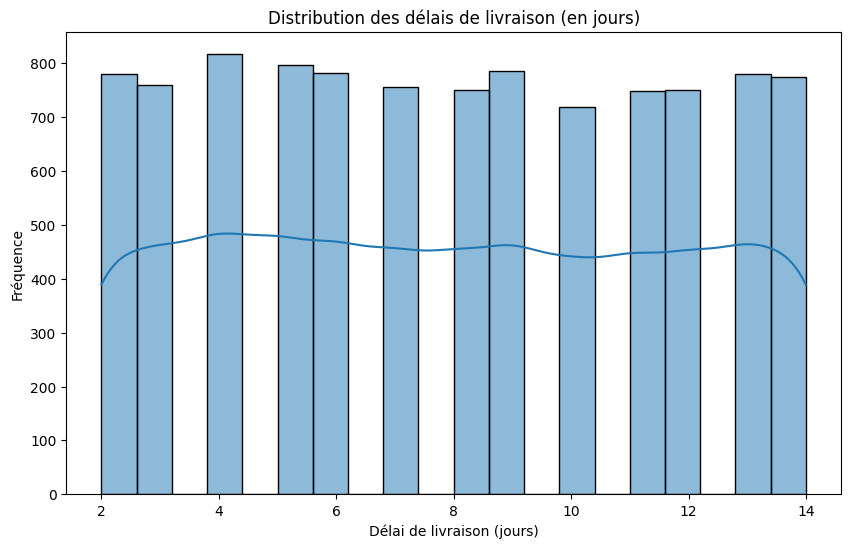

In [32]:
# Distribution des délais de livraison réels
plt.figure(figsize=(10, 6))
sns.histplot(df['délai_livraison_jours'], kde=True, bins=20)
plt.title('Distribution des délais de livraison (en jours)')
plt.xlabel('Délai de livraison (jours)')
plt.ylabel('Fréquence')
plt.show()

### Interprétation : Distribution des Délais de Livraison (en jours)

Cet histogramme montre la fréquence des différents délais de livraison, allant de **2 à 14 jours**.

*   **Caractéristique principale :** La distribution est **relativement uniforme**. Aucun délai de livraison spécifique ne se distingue par une fréquence nettement supérieure aux autres.
*   **Fréquences :** Les occurrences pour chaque délai oscillent entre environ 720 et un peu plus de 800. Le délai de 4 jours est légèrement le plus fréquent (environ 820) et celui de 10 jours le moins fréquent (environ 720), mais les différences globales entre les fréquences des différents délais sont modérées.
*   **Conclusion :** Les délais de livraison sont assez **équitablement répartis** sur la plage observée (2 à 14 jours), plutôt que d'être fortement concentrés autour d'une valeur centrale. La courbe d'estimation de densité (KDE) confirme cette tendance générale, montrant de légères fluctuations mais pas de pic dominant.

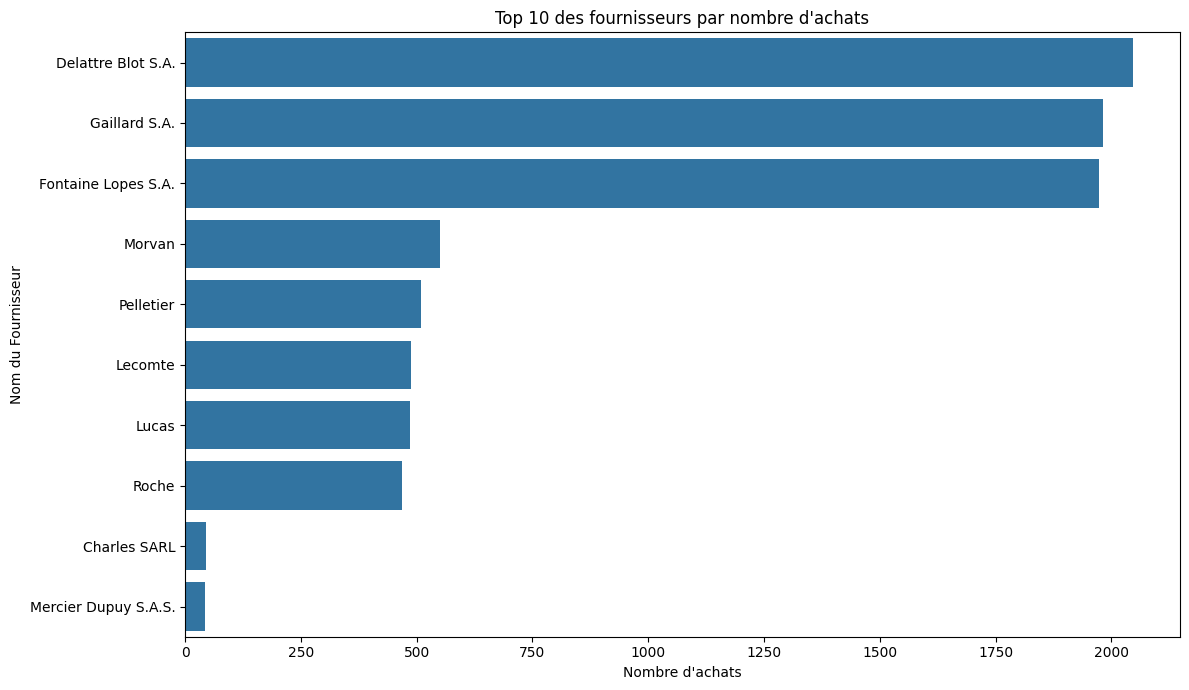

In [19]:

# Top 10 Fournisseurs par nombre d'achats
plt.figure(figsize=(12, 7))
top_fournisseurs = df['nom_fournisseur'].value_counts().nlargest(10)
sns.barplot(x=top_fournisseurs.values, y=top_fournisseurs.index)
plt.title('Top 10 des fournisseurs par nombre d\'achats')
plt.xlabel('Nombre d\'achats')
plt.ylabel('Nom du Fournisseur')
plt.tight_layout()
plt.show()

### Interprétation : Top 10 des fournisseurs par nombre d'achats

Ce graphique montre le classement des 10 principaux fournisseurs par volume d'achats.

**Points Clés :**

1.  **Top 3 Dominant :**
    *   **Delattre Blot S.A. :** ~2050-2100 achats (1er)
    *   **Gaillard S.A. :** ~1950-1980 achats (2ème)
    *   **Fontaine Lopes S.A. :** ~1900-1950 achats (3ème)
    *   *Ces trois fournisseurs concentrent la majorité des achats.*

2.  **Groupe Intermédiaire (4ème-8ème) :**
    *   **Morvan :** ~500-550 achats
    *   **Pelletier, Lecomte, Lucas :** ~450-500 achats chacun
    *   **Roche :** ~400-450 achats
    *   *Volume d'achats modéré, significativement plus bas que le top 3.*

3.  **Bas du Classement (9ème-10ème) :**
    *   **Charles SARL & Mercier Dupuy S.A.S. :** < 50 achats chacun
    *   *Volume d'achats très faible, marginal.*

**Synthèse :**
Forte concentration des achats sur les trois premiers fournisseurs. Un groupe de cinq fournisseurs a un volume modéré. Les deux derniers ont une part très faible. Écarts importants entre ces groupes.

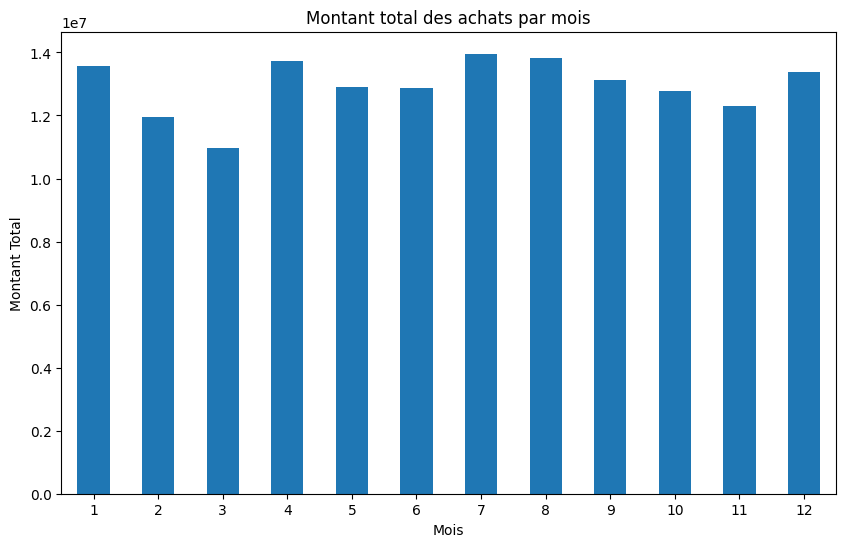

In [20]:
# Montant total des achats par mois
achats_par_mois = df.groupby('mois')['montant_total'].sum()
plt.figure(figsize=(10, 6))
achats_par_mois.plot(kind='bar')
plt.title('Montant total des achats par mois')
plt.xlabel('Mois')
plt.ylabel('Montant Total')
plt.xticks(rotation=0)
plt.show()


### Interprétation : Montant total des achats par mois

Ce graphique à barres verticales illustre le montant total des achats (en unités monétaires, l'axe Y va jusqu'à 1.4x10⁷, donc probablement en dizaines de millions) pour chaque mois de l'année (1 à 12).

**Points Clés :**

1.  **Pics d'achats (Montants les plus élevés) :**
    *   **Mois 7 (Juillet) :** Montant le plus élevé, approchant 1,4 x 10⁷ (environ 13,9 millions).
    *   **Mois 4 (Avril) :** Très élevé, environ 1,38 x 10⁷.
    *   Les mois 1 (Janvier), 9 (Septembre), et 12 (Décembre) montrent également des montants élevés, tous supérieurs à 1,3 x 10⁷.

2.  **Creux d'achats (Montants les plus bas) :**
    *   **Mois 3 (Mars) :** Montant le plus bas, environ 1,1 x 10⁷.
    *   **Mois 2 (Février) :** Relativement bas, autour de 1,2 x 10⁷.

3.  **Tendance Générale :**
    *   Les montants d'achats sont globalement élevés et relativement stables tout au long de l'année, oscillant principalement entre 1,1 x 10⁷ et 1,4 x 10⁷.
    *   Il n'y a pas de chute drastique ou de saisonnalité très prononcée, mais plutôt des fluctuations mensuelles.

**Synthèse :**
L'activité d'achat, en termes de montant, est soutenue sur l'ensemble de l'année. Juillet et Avril se distinguent par les montants les plus importants, tandis que Mars enregistre le plus faible. Les variations mensuelles existent mais ne dénotent pas de période de forte baisse prolongée.

In [34]:

print("\n--- Classification des fournisseurs ---")


supplier_features = df.groupby('id_fournisseur').agg(
    nom_fournisseur=('nom_fournisseur', 'first'),
    fiabilite=('fiabilité', 'mean'), 
    delai_moyen_livraison_specifique=('délai_moyen_jours', 'mean'), 
    nombre_achats=('id_achat', 'count'),
    montant_total_achats=('montant_total', 'sum'),
    quantite_totale_achetee=('quantité', 'sum'),
    prix_unitaire_moyen_paye=('prix_unitaire', 'mean'),
    delai_livraison_observe_moyen=('délai_livraison_jours', 'mean') 
).reset_index()

supplier_features['montant_moyen_par_achat'] = supplier_features['montant_total_achats'] / supplier_features['nombre_achats']

print("\nCaractéristiques agrégées par fournisseur :")
supplier_features.head().T


--- Classification des fournisseurs ---

Caractéristiques agrégées par fournisseur :


,0,1,2,3,4
id_fournisseur,S001,S002,S003,S004,S005
nom_fournisseur,Lecomte et Fils,Morvan,Germain et Fils,Philippe,Blanc
fiabilite,0.84,0.86,0.85,0.57,0.65
delai_moyen_livraison_specifique,10.0,9.0,10.0,9.0,13.0
nombre_achats,40,551,29,32,42
montant_total_achats,576134.75,8911703.35,433349.2,605874.4,813314.3
quantite_totale_achetee,3935,56800,2325,3780,4520
prix_unitaire_moyen_paye,157.78625,155.404682,162.196207,159.340625,169.903333
delai_livraison_observe_moyen,8.9,7.911071,8.413793,8.3125,7.047619
montant_moyen_par_achat,14403.36875,16173.69029,14943.075862,18933.575,19364.62619


In [22]:
import plotly.express as px


if 'supplier_features' not in locals() and 'df' in locals():
    print("Recalcul de supplier_features...")
    supplier_features = df.groupby('id_fournisseur').agg(
        nom_fournisseur=('nom_fournisseur', 'first'),
        fiabilite=('fiabilité', 'mean'), # Devrait être unique par fournisseur
        delai_moyen_livraison_specifique=('délai_moyen_jours', 'mean'), # Devrait être unique
        nombre_achats=('id_achat', 'count'),
        montant_total_achats=('montant_total', 'sum')

    ).reset_index()
elif 'supplier_features' not in locals() and 'df' not in locals():
    print("Erreur : DataFrame 'df' et 'supplier_features' non trouvés. Veuillez exécuter les étapes précédentes.")
    exit()


print("\n--- Création du graphique interactif avec Plotly pour la classification des fournisseurs ---")

fig_plotly = px.scatter(
    supplier_features,
    x='fiabilite',
    y='delai_moyen_livraison_specifique',
    size='nombre_achats',  
    color='nom_fournisseur',
    hover_name='nom_fournisseur',  
    hover_data={ 
        'fiabilite': ':.2f',
        'delai_moyen_livraison_specifique': True, 
        'nombre_achats': True,
        'montant_total_achats': ':,.0f'
    },
    title='Fiabilité vs. Délai moyen de livraison des fournisseurs (Interactif)',
    labels={
        'fiabilite': 'Fiabilité du fournisseur',
        'delai_moyen_livraison_specifique': 'Délai moyen de livraison spécifié (jours)',
        'nombre_achats': 'Nombre d\'achats',
        'nom_fournisseur': 'Fournisseur'
    }
)


fig_plotly.update_layout(
    xaxis_title='Fiabilité du fournisseur',
    yaxis_title='Délai moyen de livraison spécifié (jours)',
    legend_title='Fournisseurs',

)
fig_plotly.update_traces(marker=dict(sizemin=5))

fig_plotly.show()


--- Création du graphique interactif avec Plotly pour la classification des fournisseurs ---


### Interprétation : Fiabilité vs. Délai moyen de livraison des fournisseurs

Ce nuage de points compare les fournisseurs selon :
*   **Fiabilité du fournisseur (axe X) :** Plus le score est élevé (vers la droite), mieux c'est.
*   **Délai moyen de livraison spécifié en jours (axe Y) :** Plus le délai est court (vers le bas), mieux c'est.
*   La **taille des bulles** indique vraisemblablement l'importance du fournisseur (ex: volume d'achats).

**Points Clés :**

1.  **Fournisseurs Optimaux (Haute fiabilité, Délai court - en bas à droite) :**
    *   **Pelletier (jaune) :** Se distingue nettement avec une fiabilité proche de 1 (excellente) et un délai très court (~3 jours).
    *   **Gautier (turquoise) :** Bonne fiabilité (~0.85) et délai court (~4 jours).
    *   **Lucas (bleu foncé) :** Bonne fiabilité (~0.9) et délai court (~5 jours).

2.  **Fournisseurs à Volume Important avec Compromis :**
    *   **Morvan (orange, grosse bulle) :** Fiabilité excellente (~1.0) mais délai de livraison long (~11 jours).
    *   **Gaillard S.A. (vert clair, grosses bulles) :** Fiabilité moyenne (~0.63 et ~0.75 pour ses deux points principaux) et délais moyens (~7-8 jours).
    *   **Fischer (rose vif, grosse bulle) :** Fiabilité plus faible (~0.55) mais délai de livraison moyen (~6 jours).

3.  **Fournisseurs Moins Performants sur ces Critères :**
    *   **Germain et Fils (vert foncé) :** Fiabilité moyenne (~0.68) mais délai le plus long (~14 jours).
    *   **Philippe (violet foncé) :** Faible fiabilité (~0.55) et délai long (~10 jours).
    *   **Lecomte et Fils (violet clair) :** Fiabilité la plus basse (~0.5) et délai moyen (~7 jours).

**Synthèse :**
L'idéal est un fournisseur positionné en bas à droite du graphique. **Pelletier** apparaît comme le plus équilibré et performant. Les fournisseurs avec de grosses bulles (volume important) comme **Morvan, Gaillard S.A., et Fischer** nécessitent une analyse de compromis entre leur volume/importance et leur performance en termes de fiabilité/délai.


--- Classification des fournisseurs avec K-Means (adapté) ---

Détermination du nombre optimal de clusters (Méthode du Coude)...


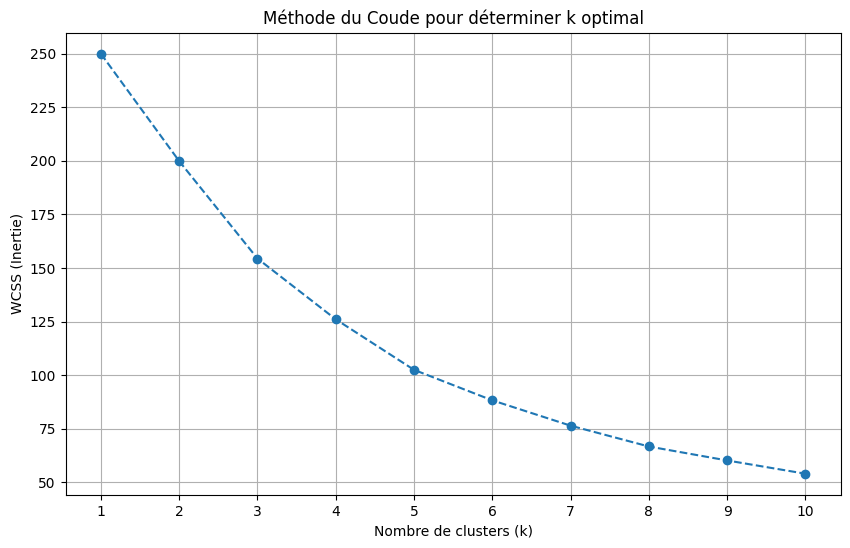

Entrée invalide. Utilisation de k=3 par défaut.

Application de K-Means avec k=3 clusters...

Classification par K-Means (exemple) :
   nom_fournisseur  cluster_kmeans
0  Lecomte et Fils               0
1           Morvan               0
2  Germain et Fils               0
3         Philippe               1
4            Blanc               1

Caractéristiques moyennes par cluster :


,fiabilite,delai_moyen_livraison_specifique,delai_livraison_observe_moyen,montant_moyen_par_achat,nombre_achats
cluster_kmeans,,,,,
0,0.876818,9.227273,8.058406,14300.114355,101.045455
1,0.628400,7.320000,7.632102,16733.667085,71.080000
2,0.640000,7.000000,7.982274,15206.042223,2000.000000


In [35]:
from sklearn.preprocessing import StandardScaler

supplier_feature = df.groupby('id_fournisseur').agg(
    nom_fournisseur=('nom_fournisseur', 'first'),
    fiabilite=('fiabilité', 'mean'),
    delai_moyen_livraison_specifique=('délai_moyen_jours', 'mean'),
    nombre_achats=('id_achat', 'count'),
    montant_total_achats=('montant_total', 'sum'),
    quantite_totale_achetee=('quantité', 'sum'),
    prix_unitaire_moyen_paye=('prix_unitaire', 'mean'),
    delai_livraison_observe_moyen=('délai_livraison_jours', 'mean'),
    delai_livraison_observe_std=('délai_livraison_jours', 'std'),
    ville=('ville', 'first'),
    pays=('pays', 'first')
).reset_index()

supplier_feature['delai_livraison_observe_std'].fillna(0, inplace=True)
supplier_feature['montant_moyen_par_achat'] = supplier_feature['montant_total_achats'] / supplier_feature['nombre_achats']

print("\n--- Classification des fournisseurs avec K-Means (adapté) ---")


features_for_clustering = [
    'fiabilite',
    'delai_moyen_livraison_specifique',
    'delai_livraison_observe_moyen',
    'montant_moyen_par_achat',
    'nombre_achats'
]
X_cluster = supplier_feature[features_for_clustering].copy()

# Corrected NaN handling for X_cluster
for col in X_cluster.columns:
    if X_cluster[col].isnull().any():
        print(f"Attention: Valeurs NaN trouvées dans la colonne '{col}' pour le clustering. Remplacement par la moyenne.")
        # FIX APPLIED HERE:
        X_cluster[col] = X_cluster[col].fillna(X_cluster[col].mean())
        
# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


print("\nDétermination du nombre optimal de clusters (Méthode du Coude)...")
wcss = []
k_range = range(1, 11)

for i in k_range:
    kmeans_elbow = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans_elbow.fit(X_scaled)
    wcss.append(kmeans_elbow.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Méthode du Coude pour déterminer k optimal')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('WCSS (Inertie)')
plt.xticks(list(k_range))
plt.grid(True)
plt.show()
try:
    optimal_k = int(input("D'après le graphique du coude, quel est le nombre optimal de clusters (k) ? Entrez un nombre entier : "))
    if not (1 <= optimal_k <= 10): # Vérifier si k est dans la plage testée
        print("Nombre de clusters hors de la plage testée. Utilisation de k=3 par défaut.")
        optimal_k = 3
except ValueError:
    print("Entrée invalide. Utilisation de k=3 par défaut.")
    optimal_k = 3


print(f"\nApplication de K-Means avec k={optimal_k} clusters...")
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
supplier_feature['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

print("\nClassification par K-Means (exemple) :")
print(supplier_feature[['nom_fournisseur', 'cluster_kmeans']].head())


print("\nCaractéristiques moyennes par cluster :")
cluster_analysis = supplier_feature.groupby('cluster_kmeans')[features_for_clustering].mean()
cluster_analysis



In [24]:

supplier_feature['cluster_kmeans'] = supplier_feature['cluster_kmeans'].astype('category')

print("\nCréation du graphique interactif Plotly pour les clusters K-Means...")
fig_kmeans_plotly = px.scatter(
    supplier_feature,
    x='fiabilite',  # Axe X
    y='delai_livraison_observe_moyen',
    color='cluster_kmeans',
    size='nombre_achats',
    hover_name='nom_fournisseur',
    hover_data={
        'fiabilite': ':.2f',
        'delai_moyen_livraison_specifique': ':.1f',
        'delai_livraison_observe_moyen': ':.1f',
        'montant_moyen_par_achat': ':,.0f',
        'nombre_achats': True,
        'cluster_kmeans': True, 
        'ville': True,
        'pays': True
    },
    title=f'Clusters de fournisseurs par K-Means (k={optimal_k})',
    labels={
        'fiabilite': 'Fiabilité',
        'delai_livraison_observe_moyen': 'Délai Observé Moyen (j)',
        'nombre_achats': 'Nb Achats',
        'cluster_kmeans': 'Cluster'
    },
    color_discrete_sequence=px.colors.qualitative.Vivid # Autre palette de couleurs
)

fig_kmeans_plotly.update_layout(
    legend_title_text='Cluster K-Means'
)
fig_kmeans_plotly.update_traces(marker=dict(sizemin=5))
fig_kmeans_plotly.show()

print("\nScript de classification K-Means et visualisation Plotly terminé.")


Création du graphique interactif Plotly pour les clusters K-Means...



Script de classification K-Means et visualisation Plotly terminé.


### Interprétation : Clusters de fournisseurs par K-Means (k=3)

Ce nuage de points visualise trois clusters de fournisseurs (0, 1, 2) basés sur leur **Fiabilité** (axe X) et leur **Délai Observé Moyen en jours** (axe Y). Les gros points turquoise (Cluster 2) représentent les centroïdes de ce cluster, ou les fournisseurs eux-mêmes si ce cluster est très petit.

**Analyse des Clusters :**

1.  **Cluster 0 (Orange) : Fiables mais plus lents**
    *   **Fiabilité :** Généralement élevée (principalement > 0.8).
    *   **Délai :** Variable, mais tend à être moyen à long (7 à 9+ jours).
    *   *Profil :* Fournisseurs sur lesquels on peut compter, mais avec des délais de livraison potentiellement plus longs.

2.  **Cluster 1 (Violet) : Moins fiables, délais variables**
    *   **Fiabilité :** Généralement faible à moyenne (principalement entre 0.5 et 0.7).
    *   **Délai :** Assez variable (6.5 à 9 jours).
    *   *Profil :* Fournisseurs présentant un risque plus élevé en termes de respect des engagements, avec des délais de livraison hétérogènes.

3.  **Cluster 2 (Turquoise - gros points) : Performants moyens et constants (petit groupe)**
    *   **Fiabilité :** Moyenne (entre ~0.5 et ~0.75).
    *   **Délai :** Relativement constant et moyen (autour de 8 jours).
    *   *Profil :* Petit groupe de fournisseurs aux performances moyennes et prévisibles sur ces deux critères. Leur taille plus importante sur le graphique pourrait indiquer un volume d'affaires plus conséquent ou qu'ils sont les centroïdes du cluster.

**Synthèse :**
Le K-Means a segmenté les fournisseurs en :
*   Un groupe de **fournisseurs fiables mais potentiellement lents** (Orange).
*   Un groupe de **fournisseurs moins fiables aux délais variables** (Violet).
*   Un petit groupe de **fournisseurs aux performances moyennes et constantes** (Turquoise).
Cette segmentation permet d'adapter les stratégies d'approvisionnement en fonction du profil de risque et des besoins en délai.

In [27]:
# --- 2. PCA POUR VISUALISATION 3D INTERACTIVE AVEC PLOTLY EXPRESS ---
print("\nPréparation de la visualisation 3D des clusters avec PCA...")
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3'], index=supplier_feature.index)
pca_df['cluster'] = supplier_feature['cluster_kmeans']
pca_df['nom_fournisseur'] = supplier_feature['nom_fournisseur']
# Add other features for hover information if desired
for feature in features_for_clustering:
    pca_df[feature] = supplier_feature[feature]

print("Affichage du scatter plot 3D interactif des clusters (PCA)...")
fig_pca_3d = px.scatter_3d(pca_df,
                            x='PC1',
                            y='PC2',
                            z='PC3',
                            color='cluster',  # Color by cluster
                            symbol='cluster', # Different symbol for each cluster
                            hover_name='nom_fournisseur', # Show supplier name on hover
                            hover_data=features_for_clustering, # Show original features on hover
                            title=f"Visualisation 3D des clusters de fournisseurs (PCA, k={optimal_k})")
fig_pca_3d.update_layout(margin=dict(l=0, r=0, b=0, t=40)) # Adjust layout
fig_pca_3d.show()




Préparation de la visualisation 3D des clusters avec PCA...
Affichage du scatter plot 3D interactif des clusters (PCA)...


### Interprétation : Visualisation 3D des clusters de fournisseurs (PCA, k=3)

Ce graphique 3D représente les fournisseurs, positionnés selon trois composantes principales (PC1, PC2, PC3) issues d'une Analyse en Composantes Principales (PCA). Les fournisseurs sont regroupés en **trois clusters (k=3)**, identifiés par des couleurs/formes distinctes :

*   **Cluster 0 (Cercles violets)**
*   **Cluster 1 (Losanges rouges)**
*   **Cluster 2 (Carrés jaunes)**

**Observations Clés :**

1.  **Cluster 2 (Jaune) : Très Distinct**
    *   Ce cluster est clairement séparé des deux autres.
    *   Il se situe à des valeurs élevées sur l'axe PC3 (autour de 3-4).
    *   Ses valeurs sur PC1 sont plutôt négatives (autour de -1 à -2).
    *   Il contient un petit nombre de fournisseurs.
    *   *Interprétation :* Ces fournisseurs partagent des caractéristiques très spécifiques (capturées par la combinaison unique de scores sur PC1, PC2 et PC3) qui les différencient nettement des autres.

2.  **Clusters 0 (Violet) et 1 (Rouge) : Plus Proches, avec une certaine Séparation**
    *   Ces deux clusters sont plus proches l'un de l'autre que du cluster 2. Ils occupent une région plus centrale et étendue de l'espace 3D.
    *   Ils se chevauchent partiellement, surtout si l'on considère les projections sur les plans PC1-PC2.
    *   **Différenciation :**
        *   Le Cluster 1 (rouge) tend à avoir des valeurs de PC3 légèrement plus élevées et/ou des valeurs de PC1 plus positives que le Cluster 0 (violet).
        *   Le Cluster 0 (violet) semble s'étendre davantage vers des valeurs négatives de PC2 et des valeurs plus basses de PC3.
    *   *Interprétation :* Bien que distincts selon l'algorithme de clustering, les fournisseurs de ces deux groupes partagent plus de similitudes entre eux qu'avec ceux du cluster 2. Les différences qui les séparent sont plus subtiles.

**Synthèse :**

*   La PCA a permis de réduire la dimensionnalité des données des fournisseurs, et l'algorithme de clustering a identifié trois groupes.
*   Un groupe de fournisseurs (Cluster 2) est très atypique par rapport aux autres.
*   Les deux autres groupes (Clusters 0 et 1) sont plus volumineux et présentent des profils plus proches, bien que distincts.
*   Pour comprendre la nature de ces clusters, il faudrait analyser quelles variables d'origine contribuent le plus à chaque composante principale (PC1, PC2, PC3) et examiner les caractéristiques moyennes des fournisseurs au sein de chaque cluster.

**Utilité :**
Cette visualisation aide à segmenter les fournisseurs en groupes homogènes, ce qui peut être utile pour des stratégies d'achat différenciées, la gestion des risques, ou l'identification de profils de fournisseurs spécifiques.

In [28]:
#Evaluation de performance de K-means
print("\nÉvaluation de la performance de K-Means avec le score de silhouette...")
silhouette_avg = silhouette_score(X_scaled, supplier_feature['cluster_kmeans'])
print(f"Score de silhouette pour k={optimal_k} : {silhouette_avg:.2f}")


Évaluation de la performance de K-Means avec le score de silhouette...
Score de silhouette pour k=3 : 0.25
